In [2]:
from numpy import genfromtxt
import numpy as np
import math
from pylab import *
import urllib
import os
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.metrics import mean_squared_error
from __future__ import division
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lmfit import Model
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Layer, Lambda, Multiply, Add
from keras.layers import Activation
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
pl.style.use('seaborn')
pl.rc('font',family='Arial')

Using TensorFlow backend.


In [6]:
def resample_data(filename, ds):
    data = pd.read_csv(filename, delimiter=',',usecols=["fwdfld[mT]","fwdM[arb]","revfld[mT]","revM[arb]"])
    data.columns = ['fld','fwdM', 'revfld','revM']

    data.index = pd.to_datetime(data.index,unit='h')
    data_i = data.resample('2min').interpolate()

    length = data_i.shape[0]
    cut = floor(length/ds)

    trim_data = []
    data_i = data_i.reset_index(drop=True)
    data = data.reset_index(drop=True)

    for index, row in data_i.iterrows():
        if index % cut == 0:
            if len(trim_data) < ds:
                trim_data.append(row['fwdM'])
                
    return trim_data, data

### test data resampling

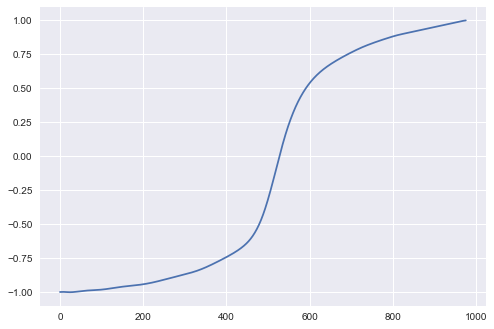

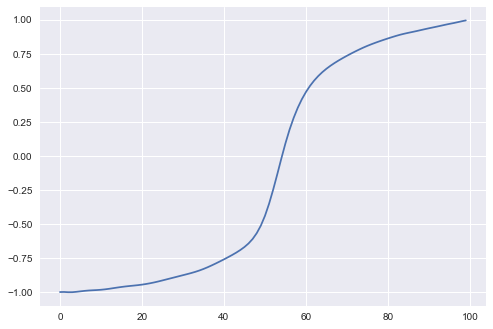

In [10]:
trim_data, orig_data = resample_data("MPS-march/15khz-50mT-22nm-g0 -MvH_intPRF.csv", 100)

pl.plot(orig_data['fwdM'])
pl.show()
pl.plot(trim_data)
pl.show()

In [11]:
freqs = []
fields = []
size = []
g = []
m = []
label = []

curves = np.zeros((100, 1200))

x = 0

for f in os.listdir('MPS-march'):
    if f[-5] == "F":
        filename = 'MPS-march/' + f
        s = str.split(f,"-")
        curves[:,x], orig_data = resample_data(filename, 100)
        x += 1
        if s[0][:-3] == "40":
            freqs.append(40200)
        elif s[0][:-3] == "25" or s[0][:-3] == "26":
            freqs.append(25250)
        elif s[0][:-3] == "15":
            freqs.append(15500)
        filedata = np.genfromtxt(filename, delimiter=',')
        fields.append(abs(filedata[1,0]))
        if s[2][:-2] == "25":
            size.append(25.2)
        elif s[2][:-2] == "28":
            size.append(27.7)
        elif s[2][:-2] == "22":
            size.append(21.9)
        if s[3][0] == "g":
            g.append(int(s[3][1:]))
            m.append(None)
            label.append('g')
        elif s[3][0] == "m":
            m.append(int(s[3][1:]))
            g.append(None)
            label.append('m')


mps_data = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'm': m, 'g':g, 'label': label})


### filter data

In [12]:
mps_data_clean = mps_data[mps_data['g'] <32]
mps_moments = curves[:,mps_data[mps_data['g'] <32].index]

print(mps_moments.shape)
print(mps_data_clean.shape)

(100, 355)
(355, 6)


In [94]:
encoding_dim = 3

input_img = Input(shape=(100,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(100, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 303       
_________________________________________________________________
dense_36 (Dense)             (None, 100)               400       
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________


In [95]:
x_train = mps_moments[:,:300].T
y_train = mps_data_clean[:300][['frequency', 'field', 'size']]
x_test = mps_moments[:,300:355].T
y_test = mps_data_clean[300:355][['frequency', 'field', 'size']]
print(x_train.shape)
print(x_test.shape)

(300, 100)
(55, 100)


In [96]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=100,
                shuffle=False,
                validation_data=(x_test, x_test))

Train on 300 samples, validate on 55 samples
Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 0.6978 - val_loss: 0.6919
Epoch 2/20
300/300 [==============================] - 0s 58us/step - loss: 0.6899 - val_loss: 0.6866
Epoch 3/20
300/300 [==============================] - 0s 37us/step - loss: 0.6855 - val_loss: 0.6830
Epoch 4/20
300/300 [==============================] - 0s 77us/step - loss: 0.6820 - val_loss: 0.6796
Epoch 5/20
300/300 [==============================] - 0s 41us/step - loss: 0.6786 - val_loss: 0.6761
Epoch 6/20
300/300 [==============================] - 0s 56us/step - loss: 0.6752 - val_loss: 0.6726
Epoch 7/20
300/300 [==============================] - 0s 67us/step - loss: 0.6717 - val_loss: 0.6692
Epoch 8/20
300/300 [==============================] - 0s 47us/step - loss: 0.6683 - val_loss: 0.6657
Epoch 9/20
300/300 [==============================] - 0s 42us/step - loss: 0.6648 - val_loss: 0.6622
Epoch 10/20
300/300 [==========================

In [97]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)

(55, 100)


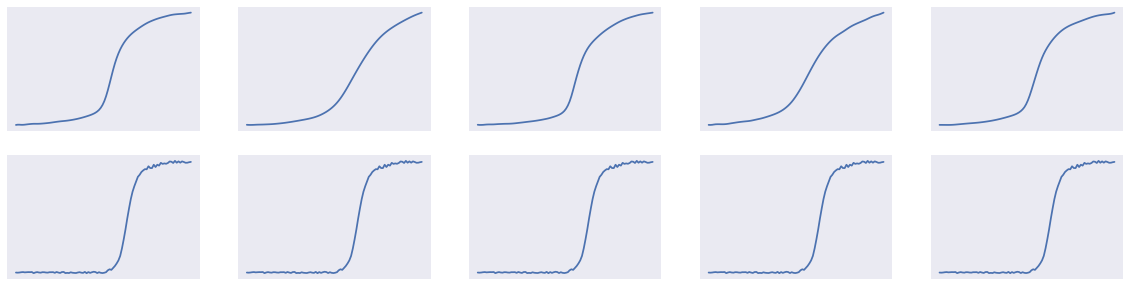

In [101]:
n = 5
pl.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = pl.subplot(2, n, i + 1)
    pl.plot(x_test[i+10,:])
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = pl.subplot(2, n, i + 1 + n)
    pl.plot(decoded_imgs[i+10,:])
    pl.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
pl.show()